# Pokémon Changes Through the Generations


This document contains the code for the project. In my personal opinion I feel like recent Pokémon are bigger and more fancy than they used to be. Therefore, does this project concider the weights of all the Pokémon that have excited, and we will test the hypothesis of whether Pokémon are getting larger (by weight) over time. 

The entire project can be found on my [github](https://github.com/ylvao/HEL-8048).

In [13]:
import kagglehub

# Using the Kaggle API requires a token including a username and key
kagglehub.login() 

In [11]:
# Importing the necessary python libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [14]:
# Download CVS data file from Kaggle and saving the download path to be used later
dataset_path = kagglehub.dataset_download('rounakbanik/pokemon', path='pokemon.csv')


# Can also use the CVS data file included in this repository by uncommenting the line bellow in the notebook
# dataset_path = 'pokemon.csv'

In [15]:
# Makes a list of all different types of Pokémon
types = []
with open(dataset_path, newline='') as data:
    reader = csv.DictReader(data)
    for row in reader:
        types.append(row['type1'])
types = list(set(types))


# Initialize dictionary for generations with corresponding weights
gen_weights  = {str(i): [] for i in range(1, 8)}

# Initialize dictionary for type with corresponding weights            
type_weights = {i: [] for i in types}

# Read CSV and populate the above dictionaries with the weights and respective generation
with open(dataset_path, newline='') as data:
    reader = csv.DictReader(data)
    for row in reader:
        gen = row['generation']
        if gen in gen_weights and row['weight_kg']:
            gen_weights[gen].append(float(row['weight_kg']))
        type = row['type1']
        if type in type_weights and row['weight_kg']:
            type_weights[type].append(float(row['weight_kg']))
            


## Introducing functions used in the project

In [16]:
# Crate function to emove top and right axis for visualization purposes
def remove_top_right_axis():
    '''
    Removes the top and right spines (borders) from the current plot.

    This function modifies the current active axis (`plt.gca()`) by hiding
    the top and right spines, making the plot visually cleaner.

    Usage:
    Call this function after creating a plot to remove unnecessary borders.

    Example:
    >>> import matplotlib.pyplot as plt
    >>> plt.plot([1, 2, 3], [4, 5, 6])
    >>> remove_top_right_axis()
    >>> plt.show()
    '''
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# Function to compute mean
def find_mean(lst):
    '''
    Calculates the mean (average) of a given list of numbers.

    Parameters:
    lst (list): A list of numerical values.

    Returns:
    float: The mean of the list if it is not empty.
    int: Returns 0 if the list is empty.

    Example:
    >>> find_mean([1, 2, 3, 4, 5])
    3.0
    >>> find_mean([])
    0
    '''
    if len(lst) != 0:
        return sum(lst) / len(lst)
    else:
        return 0

# Function to compute standard deviation
def find_stdev(lst):
    '''
    Calculates the standard deviation of a given list of numbers.

    Standard deviation measures the dispersion of data points relative 
    to the mean.

    Parameters:
    lst (list): A list of numerical values.

    Returns:
    float: The standard deviation of the list if it is not empty.
    int: Returns 0 if the list is empty.

    Example:
    >>> find_stdev([1, 2, 3, 4, 5])
    1.4142135623730951
    >>> find_stdev([])
    0
    '''
    if len(lst) != 0:
        mean = find_mean(lst)
        variance = sum((x - mean) ** 2 for x in lst) / len(lst)
        return np.sqrt(variance)
    else:
        return 0 

# Calculate the median value depending on wheather the list is odd or even
def find_median(lst):
    '''
    Calculates the median of a given list of numbers.

    The median is the middle value of a sorted list. If the list has an odd number 
    of elements, the middle element is returned. If the list has an even number 
    of elements, the average of the two middle elements is returned.

    Parameters:
    lst (list): A list of numerical values.

    Returns:
    float: The median value of the list.

    Example:
    >>> find_median([3, 1, 2])
    2
    >>> find_median([4, 1, 3, 2])
    2.5
    '''
    if len(lst) == 0:
        return None  # Edge case: empty list

    lst.sort()  # Ensure the list is sorted before finding the median

    n = len(lst)
    mid = n // 2  # Middle index

    if n % 2 == 1:  # Odd number of elements
        return lst[mid]
    else:  # Even number of elements
        return (lst[mid] + lst[mid - 1]) / 2


# Function to filter Pokémon that are 400 kg or more
def filter_heavy_pokemon(gen_weights, max_weight=400):
    '''
    Filters Pokémon by weight, keeping only those that meet or exceed the given weight threshold.

    Parameters:
    gen_weights (dict): A dictionary where keys are Pokémon generations (e.g., 'Gen 1', 'Gen 2')
                        and values are lists of Pokémon weights in that generation.
    max_weight (int, optional): The minimum weight (in any unit) a Pokémon must have 
                                 to be included in the filtered result. Default is 400.

    Returns:
    dict: A dictionary containing only Pokémon that meet or exceed the weight threshold, 
          with the same generational structure as the input.

    Example:
    >>> gen_weights = {
    ...     "Gen 1": [200, 500, 350, 800],
    ...     "Gen 2": [100, 450, 600, 300]
    ... }
    >>> filter_heavy_pokemon(gen_weights, max_weight=400)
    {'Gen 1': [500, 800], 'Gen 2': [450, 600]}
    '''
    return {gen: [weight for weight in weights if weight >= max_weight] for gen, weights in gen_weights.items()}

# Function to create subplots with the correct customization
def create_pie(values, title, nr, axes, labels, colors):
    '''
    Creates a pie chart on a specified subplot axis.

    Parameters:
    values (dict): A dictionary where keys represent categories, and values represent 
                   numerical data to be visualized in the pie chart.
    title (str): The title of the pie chart.
    nr (int): The index of the subplot in the axes array where the pie chart should be drawn.
    axes (array-like): An array of subplot axes (e.g., created using `plt.subplots()`).
    labels (list): A list of category labels for the pie chart.
    colors (list): A list of colors corresponding to each category in the pie chart.

    Returns:
    None: The function modifies the given `axes` by adding a pie chart.

    Example:
    >>> import matplotlib.pyplot as plt
    >>> fig, axes = plt.subplots(1, 2)  # Create two subplots
    >>> values = {'A': 30, 'B': 50, 'C': 20}
    >>> labels = list(values.keys())
    >>> colors = ['red', 'blue', 'green']
    >>> create_pie(values, "Example Pie Chart", 0, axes, labels, colors)
    >>> plt.show()
    '''
    axes[nr].pie(list(values.values()), labels=labels, autopct='%1.1f%%', textprops={'fontsize': 12}, startangle=140, colors=colors)
    axes[nr].set_title(title)


## Scatter Plot of all Weights

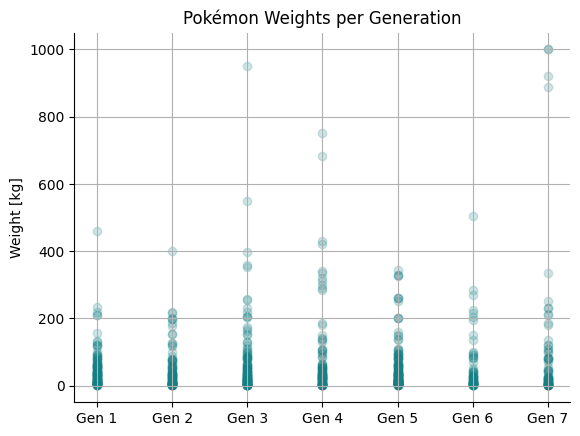

In [35]:
for i in range(1, 8):
    plt.scatter([f'Gen {i}' for j in range(len(gen_weights[str(i)]))], gen_weights[str(i)], color="#138086", alpha=0.2) 
    
remove_top_right_axis()
plt.ylabel("Weight [kg]")
plt.title("Pokémon Weights per Generation")
plt.grid(True)
plt.show()

Based on the plot above, it seems like Gen 7 has some heavier Pokémon compared to the other generations. In addition Gen 3 has a heavy one.

## Density plot of weights


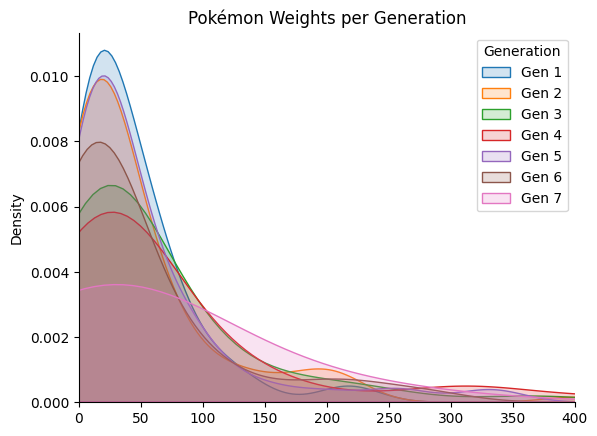

In [34]:
# Generate density plot for each generation's weights
for i in range(1, 8):
    sns.kdeplot(gen_weights[str(i)], label=f'Gen {i}', fill=True, alpha=0.2)

# Customize plot
remove_top_right_axis()
plt.xlim(0, 400)
plt.ylabel("Density")
plt.title("Pokémon Weights per Generation")
# Legend shows the annotation quare in the upper right
plt.legend(title="Generation")
plt.show()


Here, it seems like Gen 7 has a larger distribution of heavier Pokémon, however, this figure is not that good. Bellow, all density distributions are shown individually, stacked above each other.

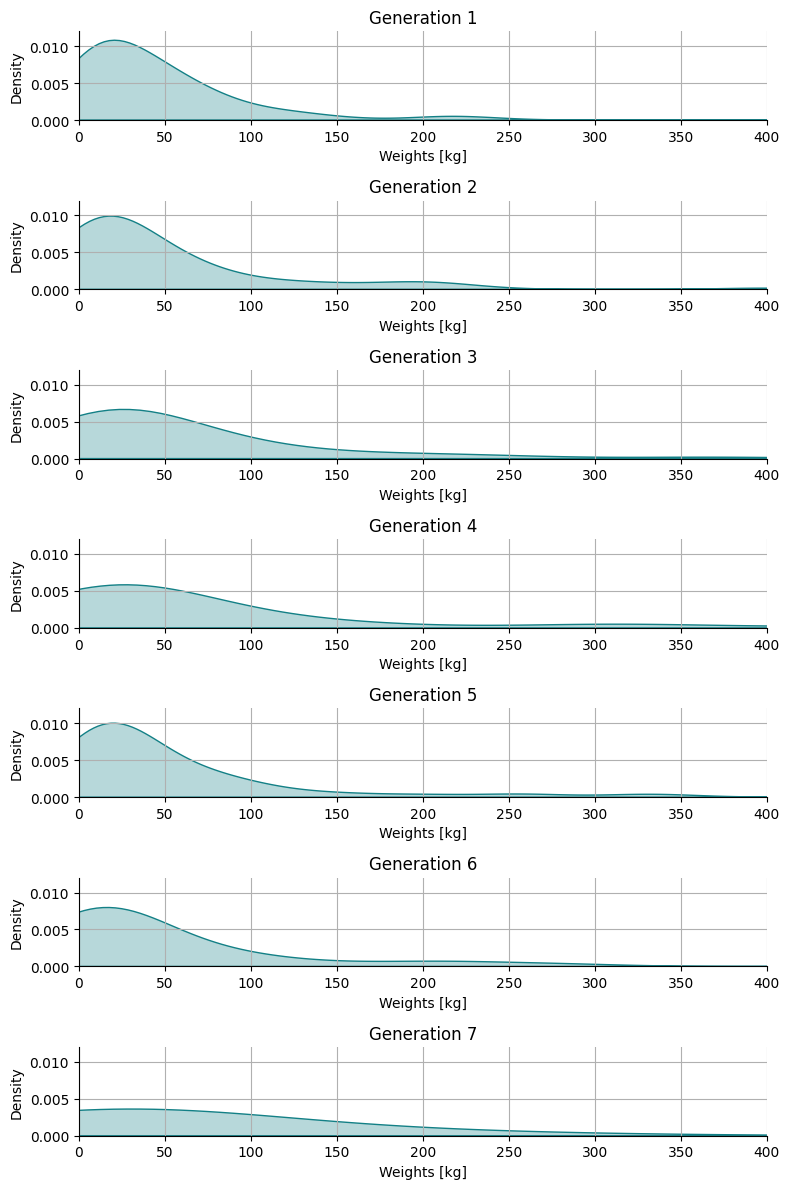

In [36]:
# Create subplots (7 rows, 1 column)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 12))

# Plot density for each generation in separate subplots
for i, ax in enumerate(axes, 1):
    sns.kdeplot(gen_weights[str(i)], ax=ax, fill=True, color="#138086", alpha=0.3)
    ax.set_title(f'Generation {i}')
    ax.set_ylabel("Density")
    ax.set_xlabel("Weights [kg]")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, 400])
    ax.set_ylim([0, 0.012])
    ax.grid(True)

# Customize 
plt.tight_layout()
plt.show()


All generations have a wigher density of Pokémon around 25 kg. Gen 7 seems to have the most spread out weight distribution and more heavier Pokémon.

## Bar Plot Showing the Average Weights

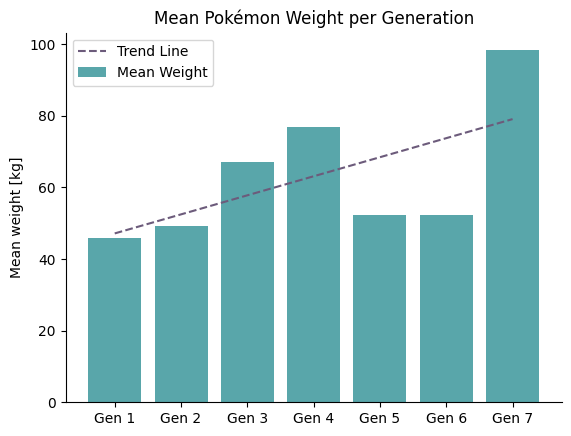

In [20]:
# Compute mean weights and standars deviations of the different generations
x_vals = np.arange(1, 8)
means  = [find_mean(gen_weights[str(i)]) for i in range(1, 8)]
stdevs   = [find_stdev(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, means, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='#6C5B7B', linestyle='--', label="Trend Line")

# Create bar plot of the avg. weights 
plt.bar(x_vals, means, tick_label=[f'Gen {i}' for i in range(1, 8)], color="#138086", alpha=0.7, label="Mean Weight")

# Plot errorbars using the standard deviation
# plt.errorbar(x_vals, means, yerr=stdevs, fmt='o', capsize=5, capthick=2, elinewidth=1, color="gray", label="Standard deviation")

# Labels and title
plt.ylabel("Mean weight [kg]")
plt.title("Mean Pokémon Weight per Generation")

# Some custumization 
remove_top_right_axis()
plt.legend()
plt.show()


Based on the average weights, it seems like the total trend is that the Pokémon are getting heavier, however, Gens 5 and 6, has an average weight more similar to Gens 1 and 2. The standard deviation for these means can be showed by uncommenting the plt.errorbar line in the notebook. However, it is by default left out, as the standard deviation is very large and thus uninformative.

## Bar Plot of the Median Weights

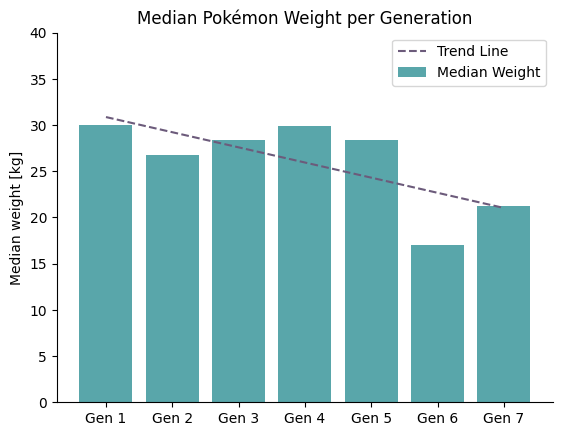

In [21]:
# Compute medial weights og the different generations
x_vals = np.arange(1, 8)
medians = [find_median(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, medians, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='#6C5B7B', linestyle='--', label="Trend Line")

# Create bar plot of the median weights 
plt.bar(x_vals, medians, tick_label=[f'Gen {i}' for i in range(1, 8)], color="#138086", alpha=0.7, label="Median Weight")


# Some custumization 
plt.ylabel("Median weight [kg]")
plt.title("Median Pokémon Weight per Generation")
plt.ylim([0, 40])
remove_top_right_axis()

plt.legend()
plt.show()


The median weight shows the oposite trend than the mean, showed earlier. This plot suggests that there are more light weight Pokémon in the newer generations, but the heavier Pokémon are heavier. However, the difference in weight between the median is much smaller than that of the mean, showing an overall smaller change of median weight between the different generations.

## Population over 400 kg

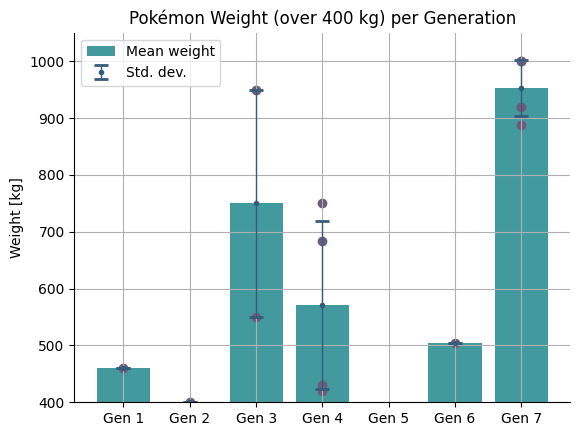

In [ ]:
# Filter Pokémon
filtered_gen_weights = filter_heavy_pokemon(gen_weights)
filtered_gen_weights["5"] = []  # If no Pokémon in Gen 5 meet criteria, use empty list

# Compute mean weights per generation
heavy_means = [find_mean(filtered_gen_weights[str(i)]) for i in range(1, 8)]

# Compute standard deviations 
heavy_stdevs = [find_stdev(filtered_gen_weights[str(i)]) for i in range(1, 8)]

# Making x-axis labels not only numbers
x_vals = [f'Gen {i}' for i in range(1, 8)]

# Plot bar chart of mean weights
plt.bar(x_vals, heavy_means, color="#138086", alpha=.8, label = "Mean weight")

# Error bar showing the standard deviation of the mean    
plt.errorbar(x_vals, heavy_means, yerr=heavy_stdevs, fmt='.', 
             capsize=5, capthick=2, elinewidth=1, color="#355C7D", label="Std. dev.")

# Scatter plot of all Pokémon weights per generation
for i in range(1, 8):
    plt.scatter([f'Gen {i}' for _ in filtered_gen_weights[str(i)]], filtered_gen_weights[str(i)], color="#6C5B7B")


# Customization
remove_top_right_axis()
plt.ylim(400, 1050)
plt.ylabel("Weight [kg]")
plt.title("Pokémon Weight (over 400 kg) per Generation")
plt.legend()
plt.show()

This plot only considers the Pokémon over 400 kg. Here it is clear that Gen 7 has the heaviest Pokémon, with Gen 3 being the generation with the second heaviest Pokémon. Based on the mean and standard deviation, it does seem like Gen 7 have a higher concentration of heaviness past the 400 kg mark, that the others. Note that ideally one would have more data for the standard deviation, but in this case it works well to show the distribution of the data points.

## Total Weight

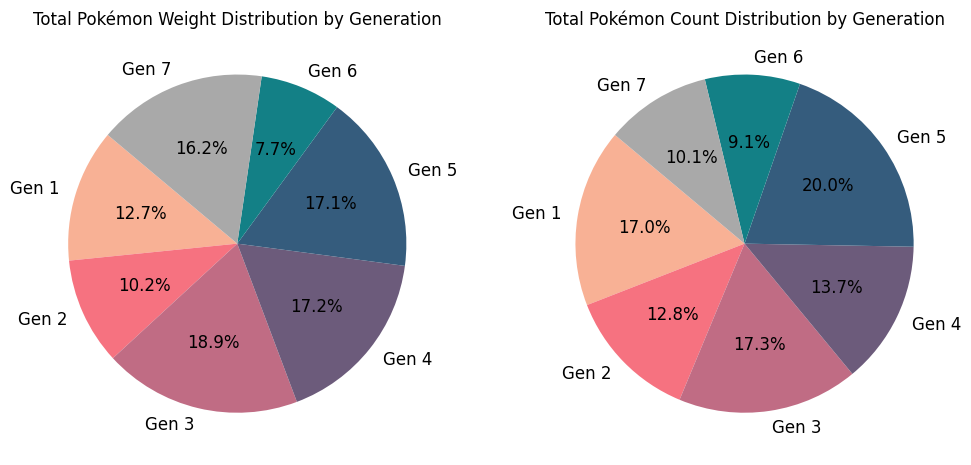

In [23]:
# Makes dictionary with the total weights of each generation
total_weights = {gen: sum(weights) for gen, weights in gen_weights.items()}

# Makes dictionary with total number of pokemon in each generation
total_count = {gen: len(amount) for gen, amount in gen_weights.items()}

# Define custom color palette with grey and purple tones
colors = ["#F8B195", "#F67280", "#C06C84", "#6C5B7B", "#355C7D", "#138086", "#a9a9a9"]
    
# Extracting labels and values for the pie chart
labels = [f'Gen {i}' for i in range(1, 8)]

# Create subplots with 1 row and 2 columns for better visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Creates the respective charts for total weight and count
create_pie(total_weights, "Total Pokémon Weight Distribution by Generation", 0, axes, labels, colors)
create_pie(total_count, "Total Pokémon Count Distribution by Generation", 1, axes, labels, colors)


The pie charts above shows us the total weight and amout of Pokémon within each generation. Here we can see that the total weight and count are often similar, for example does Gen 6 have a low total weight and at the same time few Pokémon compared to the other generations. The biggest difference is seen in Gen 7 as expected based on the awerage weights. 

## Correlation between weight, generation and type

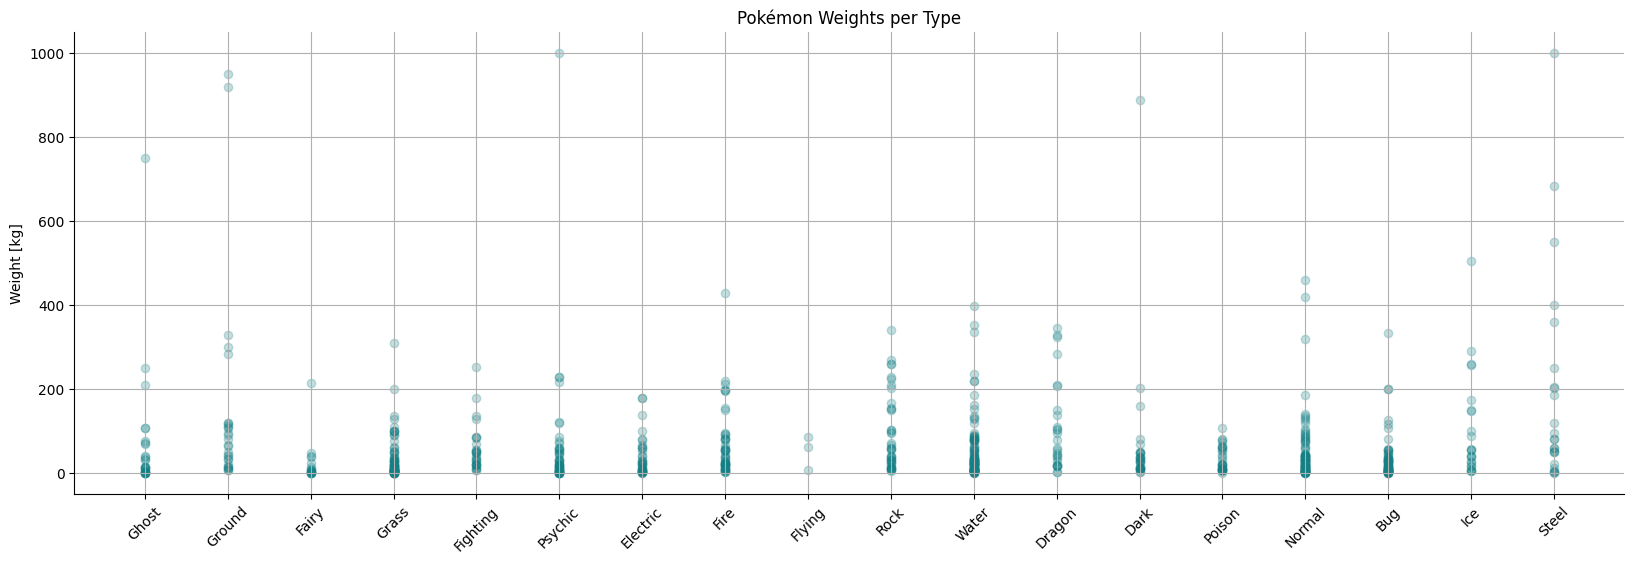

In [38]:
# Plot Pokémon Weights per Type
plt.figure(figsize=(20, 6))  # Set figure size

# Create scatter plot for the weights of each Pokémon type
for type_name in types:
    plt.scatter(
        [type_name] * len(type_weights[type_name]),  # Use type names as x-axis labels
        type_weights[type_name], color="#138086", alpha=0.25
    )

# Customization
remove_top_right_axis()
plt.ylabel("Weight [kg]")
plt.title("Pokémon Weights per Type")

# Rotate and capitalize x-axis labels for better readability
plt.xticks(ticks=range(len(types)), labels=[t.capitalize() for t in types], rotation=45)
plt.grid(True)
plt.show()

This scatter plot is used as a reference to make sure the correlation matrix bellow makes sense.

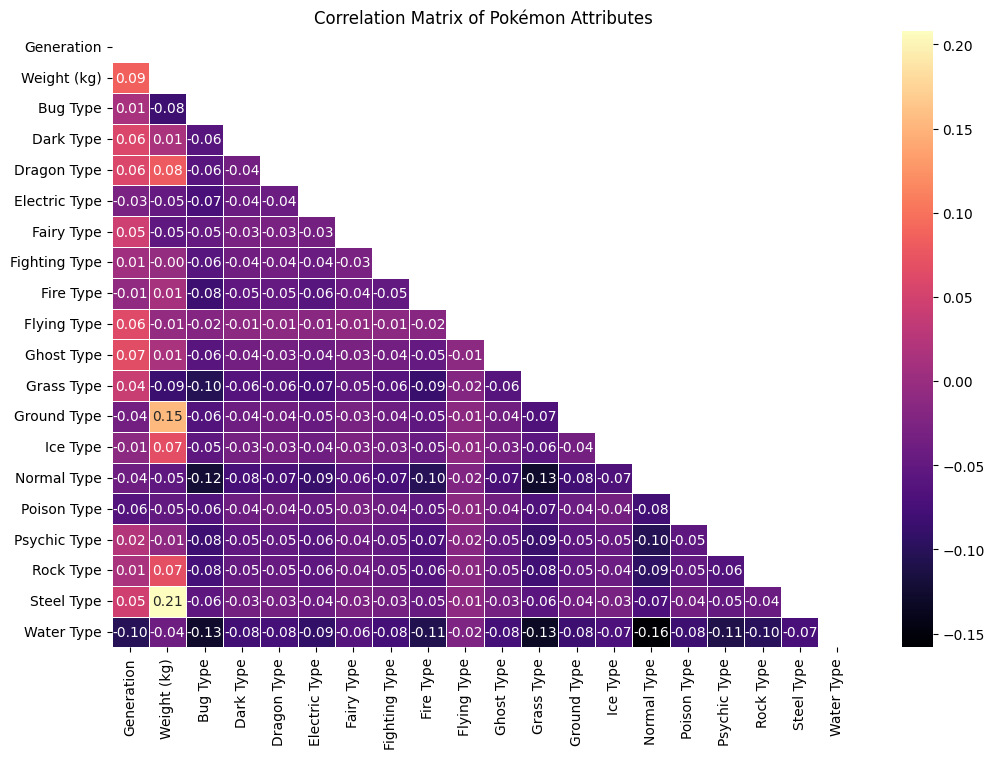

In [ ]:
# Decides to try pandas for this part
df = pd.read_csv(dataset_path)

# Select relevant columns
df_selected = df[["generation", "weight_kg", "type1"]].copy()

# Convert categorical variable 'type1' to numerical using one-hot encoding
df_encoded = pd.get_dummies(df_selected, columns=["type1"])

# Rename columns for better readability
col_rename = {
    "generation": "Generation",
    "weight_kg": "Weight (kg)"
}

# Rename type1 categories dynamically
for col in df_encoded.columns:
    if col.startswith("type1_"):
        new_name = col.replace("type1_", "").capitalize() + " Type"
        col_rename[col] = new_name

# Rename the columns based on 
df_encoded.rename(columns=col_rename, inplace=True)

# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

# Allows for removal of upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="magma", fmt=".2f", linewidths=0.5, mask=mask)
plt.title("Correlation Matrix of Pokémon Attributes")
plt.show()

The correlation matrix is based on the covariance between different variables, where 1 indicates a highly positive correlation and -1 indicates a highly negative correlation. Based on this figure, it is a slight positive correlation between the generations and the weight (~0.09), suggesting that the later generations are in fact slightly heavier. We can also see that steel and ground type Pokémons seems to be the heavier types, which makes sense concidering the previous scatter plot. And unsurprisingly, grass and bug types are the lightest.

A lot of fun information can be found here, for example, there is a quite large negative correlation between a Pokémon being both a grass and normal type, suggesting that usually if the Pokémon is a grass type it is rarely also a normal type. However, there is overall little correlation between the different types of Pokémon.